# Stock trading strategy
### Author: Hoang Van Phan
### Code executed on 6th August, 2020

In this notebook, I attempt to develop a simple trading strategy that only relies on the trend of a stock's daily open price. This is a very simplified simulation of stock trading. First, it is assumed that the bid price is equal to the ask price. Second, only the daily open price is considered.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import yfinance as yf # for downloading stock price from Yahoo Finance
import scipy.signal as signal
from datetime import datetime

# Save a list of nice looking colors
my_colors = plt.get_cmap('tab10')

## Import a stock price history

Amazon's stock price is used for testing. I will only look at stock price after 2010.

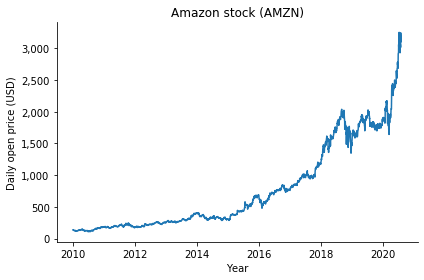

In [2]:
# Pick Amazon's stock
amzn = yf.Ticker("AMZN")
amzn_price = amzn.history(start="2010-01-01")

# Plot
fig, ax = plt.subplots(tight_layout=True)
ax.plot(amzn_price["Open"])
ax.set_xlabel("Year")
ax.set_ylabel("Daily open price (USD)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Amazon stock (AMZN)")
sns.despine(fig=fig)

## Trading strategy 1

Trading strategy 1 is simple: if stock price of a company has risen for x days (excluding weekends) consecutively after a local minimum, buy **one** share, and if stock price has fallen for x days consecutively after a local maximum, sell **all** shares.

The argument for this trading strategy is the assumption that a local minimum represents a drop in stock price, and a sustained increase after that local minimum signals that the stock price is recovering, and thus is a good time for buying. Conversely, a local maximum represents a peak in stock price, and a sustained decrease signals that the stock price is not increasing anymore, and therefore is a good time for selling.

The intended profit earning method for this strategy is through captain gains that come from selling shares at a profit.

First, I implement the trading strategy as function trading_start1(). The function will return the date and action of all taken transactions.

In [3]:
def trading_strat1(price, min_x=1, max_x=5, fees=0, budget=None):
    '''
    This function will implement trading strategy 1.
    
    A share is bought when stock price has increased consecutively for x days after the last local minimum.
    
    All currently owned shares are sold when stock price has decreased consecutively for x days after the last local maximum.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    budget: int or None
        The budget of the trader. If int, then the trade can only buy stocks if he has enough money left. If None, assume
        the trader has infinite amount of money.
        Default is None.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima = set(minima)
    maxima = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        
        # Go through gaps that are at least x-days long
        for i in combine[np.where(combine_gap >= x)]:                
            # Buy decision, check if have enough money left
            if (i in minima) and (temp_budget >= price[i+x] - fees):
                temp_budget = temp_budget - price[i+x] - fees
                trade_index.append(i+x)
                trade_info.append(1)
                n_shares += 1
                
            # Sell decision
            elif (i in maxima) and (n_shares > 0):
                temp_budget = temp_budget + price[i+x]*n_shares - fees
                trade_index.append(i+x)
                trade_info.append(-n_shares)
                n_shares = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Let us visualize the transaction history for x = 3 days, when I have an unlimited budget (ie, I can buy as many shares as I want without budget constraint).

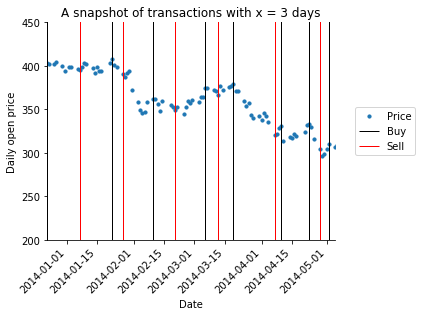

In [4]:
# Convert stock price and date to numpy arrays
amzn_price_np = amzn_price["Open"].to_numpy()
amzn_date = amzn_price.index.to_numpy()

# Implement trading strategy
amzn_dict = trading_strat1(amzn_price_np, min_x=3)

# Visualize trading patterns to confirm trading_simple() works as expected
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[amzn_dict[3][amzn_dict[3][:,1]>0,0]], 0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(amzn_date[amzn_dict[3][amzn_dict[3][:,1]<0,0]], 0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax.set_xlim(amzn_date[1000],amzn_date[1090])
ax.set_ylim(200,450)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax.set_title("A snapshot of transactions with x = 3 days")
sns.despine(fig=fig)

Now, to check how effective the trading strategy is, I will look at three numbers:
* Earning: how much money I earn from selling shares, minus how much money I spend on buying shares.
* Share worth: how much the shares I still own at the end of the period are worth.
* Profit: equal earning plus share worth, ie, profit is calculated assuming all shares are sold at the current price.

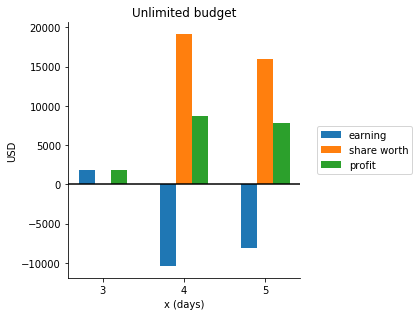

In [5]:
bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(amzn_dict.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("Unlimited budget")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

It is suspicious that the profit for x = 3 days is so low compared to x = 4 or 5 days. Let us look at the trading activities during the last 120 days.

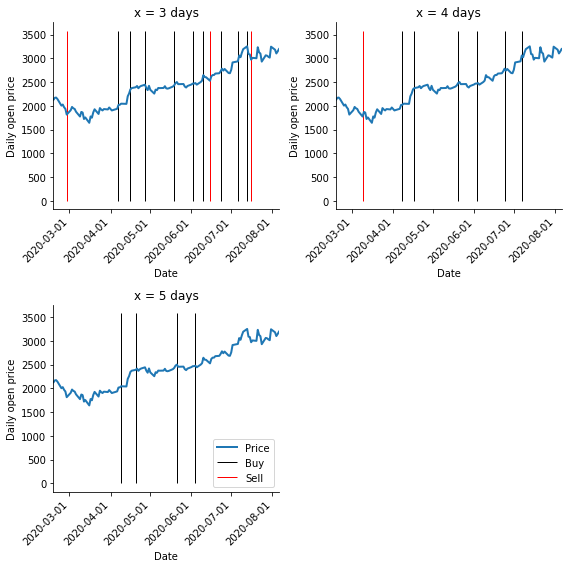

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(amzn_dict.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(amzn_date, amzn_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(amzn_date[amzn_dict[key][amzn_dict[key][:,1]>0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(amzn_date[amzn_dict[key][amzn_dict[key][:,1]<0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(amzn_date[-120],amzn_date[-1])
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="lower right")
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It seems that the profit of x = 3 days is low because the stock price is too volatile for a 3-day window, so that sometimes the share price is sold too fast, missing out on higher profit. One the other hands, because AMZN stock price at the moment is very high, the share worth of x = 4 and 5 days is so high that the profit becomes much higher than that of x = 3 days.

Let us now impose a budget of $10,000 and test the strategy again.

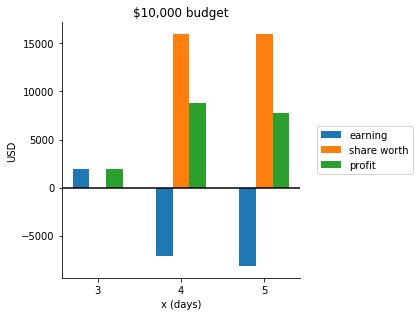

In [7]:
# Check for x = 3, 4, 5 days with a $10,000 budget
amzn_dict_10k = trading_strat1(amzn_price_np, min_x=3, max_x=5, budget=10_000)

bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict_10k.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(amzn_dict_10k.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("$10,000 budget")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

The profits when imposed a budget are very similar to when having an infinite budget.

The return on investment (ROI) is not very high with this trading strategy.

In [8]:
# Calculate ROI per year (without taking into account time value of money)
# calculate number of years, assuming 365 days/year
n_years = float(amzn_date[-1] - amzn_date[0])/1e9/60/60/24/365
for key, value in amzn_dict_10k.items():
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    profit = earning + share_worth
    print(f"Annual ROI for x = {key} days: {profit/10000/n_years*100:.2f}%")

Annual ROI for x = 3 days: 1.79%
Annual ROI for x = 4 days: 8.32%
Annual ROI for x = 5 days: 7.36%


I will now look for places that can be improved. First, can the budget be used more efficiently? Should I buy more than 1 shares when there's a consecutive increase?

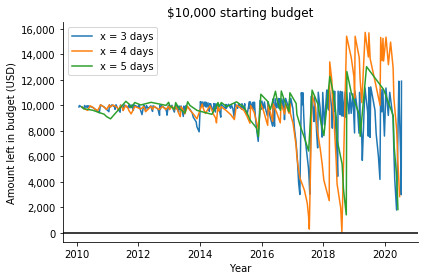

In [9]:
fig, ax = plt.subplots(tight_layout=True)
for key, value in amzn_dict_10k.items():
    ax.plot(amzn_date[value[:,0]], 10000-np.cumsum(amzn_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
ax.axhline(0, color="black")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("$10,000 starting budget")
ax.legend(loc="upper left")
sns.despine(fig=fig)

Before 2017, the budget was not fully utilized because the stock price was low, and the strategy never buys more than 1 share at a time. Therefore, **the number of shares to buy at any given time should depend on how much money the budgest still has left.**

Second, can be the buy/sell decision be improved? Let's look at the transactions of x = 4 days (because it has the highest ROI).

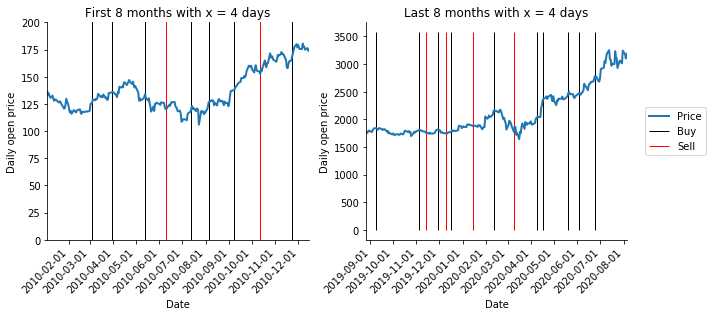

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4.5), tight_layout=True)
# All transactions
ax[0].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[0].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
             0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax[0].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
             0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax[0].set_xlim(amzn_date[0],amzn_date[240])
ax[0].set_ylim(0,200)
ax[0].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[0].get_xticks()], rotation=45, ha='right')
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Daily open price")
ax[0].set_title("First 8 months with x = 4 days")

# Last 120 days
ax[1].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[1].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
             0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax[1].vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
             0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
ax[1].set_xlim(amzn_date[-240],amzn_date[-1])
ax[1].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[1].get_xticks()], rotation=45, ha='right')
ax[1].legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Daily open price")
ax[1].set_title("Last 8 months with x = 4 days")
sns.despine(fig=fig)

It is obvious that sometimes shares are sold at a price lower than it was most recently bought. Therefore, **the sell decision should also take into account the price of previously bought shares.**

Third, recall the argument for this trading strategy about the local minima representing the a drop in stock price. I observe that there are many times when a few local minima are very close to each other. The gaps between two consecutive local minima can be as low as two days, as shown below.

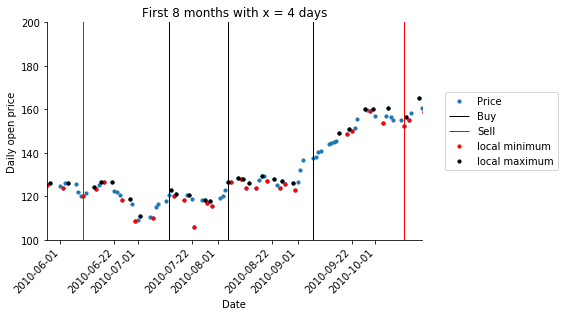

In [11]:
fig, ax = plt.subplots(figsize=(8,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]>0,0]],
          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(amzn_date[amzn_dict_10k[4][amzn_dict_10k[4][:,1]<0,0]],
          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
minima = signal.argrelmin(amzn_price_np)[0]
maxima = signal.argrelmax(amzn_price_np)[0]
ax.scatter(amzn_date[minima], amzn_price_np[minima], color='red', s=10, label="local minimum")
ax.scatter(amzn_date[maxima], amzn_price_np[maxima], color='black', s=10, label="local maximum")
ax.set_xlim(amzn_date[100],amzn_date[200])
ax.set_ylim(100,200)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.set_title("First 8 months with x = 4 days")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

Hence, **the buy decision should also look at the time of previous local minima, so that it can be executed earlier at a lower stock price.**

## Trading strategy 2

In summary, I will make three improvements to strategy 1 to arrive at strategy 2:
* If the budget allows for buying more than 1 shares, a portion of the remaining budget will be used to buy as many shares as possible.
* The selling price should be higher than the buying price of currently owned shares.
* The buy decision should also look at the time of previous local minima, so that it can be executed earlier at a lower stock price.

In [12]:
def trading_strat2(price, min_x=1, max_x=5, fees=0, buy_budget=1/3, budget=None):
    '''
    This function will implement trading strategy 2.
    
    A number of shares are bought when stock price has increased consecutively for x days after the last local minimum.
    If the budget can afford more than 1 share, use a portion of the remaining budget (specified by buy_budget) to buy as many
    shares as possible.
    If there are more than one local minima in a window of x days preceding the latest local minimum, then the buy decision
    is executed at x days after the earliest local minimum within that window.
    
    All currently owned shares are sold when stock price has decreased consecutively for x days after the last local maximum.
    In addition, the selling price must be higher than the maximum buying price of currently owned shares.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    buy_budget: float (>0 and <=1)
        When a buy decision takes place, this buy_budget ratio multiplied by the remaining budget is to be used to buy as many
        shares as possible.
        Default is 1/3.
    budget: int or None
        The budget of the trader. If int, then the trade can only buy stocks if he has enough money left. If None, assume
        the trader has infinite amount of money.
        Default is None.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima_set = set(minima)
    maxima_set = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        max_buy_price = 0 # track the maximum buying price of owned shares
        
        # Go through gaps that are at least x-days long
        for i in combine[np.where(combine_gap >= x)]:   
            # Buy decision
            if (i in minima_set):
                # Find the number of local minima within a window of (x-1) days before this local minimum
                # Use (x-1) because a buy decision cannot practically occur at a local minimum
                temp_n_minima = np.sum((minima >= (i-(x-1))) & (minima <= i))
                if temp_n_minima == 1:
                    buy_i = i + x # the index at which the buy decision occurs
                else:
                    buy_i = min(minima[minima >= (i-(x-1))]) + x
                
                # Check if enough budget is left to buy more than 1 share
                temp_n_shares_buy = (temp_budget*buy_budget - fees)/price[buy_i]
                if (temp_n_shares_buy >= 1):
                    temp_n_shares_buy = int(temp_n_shares_buy)
                elif (temp_budget >= price[buy_i] + fees):
                    temp_n_shares_buy = 1
                else:
                    continue
                temp_budget = temp_budget - temp_n_shares_buy*price[buy_i] - fees
                n_shares += temp_n_shares_buy
                trade_index.append(buy_i)
                trade_info.append(temp_n_shares_buy)
                
                # Update buying price
                max_buy_price = max([max_buy_price, price[buy_i]])
                
            # Sell decision
            elif (i in maxima_set) and (n_shares > 0):
                if (price[i+x] > max_buy_price):
                    temp_budget = temp_budget + n_shares*price[i+x] - fees
                    trade_index.append(i+x)
                    trade_info.append(-n_shares)
                    n_shares = 0
                    max_buy_price = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Testing strategy 2 with x = 3, 4, 5 days under a budget of $10,000.

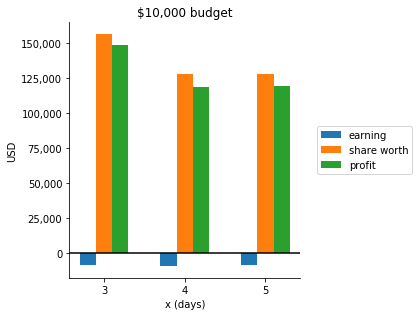

In [13]:
# Test trading strategy 2
amzn_dict2 = trading_strat2(amzn_price_np, min_x=3, budget=10_000)

bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in amzn_dict2.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticks(list(amzn_dict2.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("$10,000 budget")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

The profits now look extremely good, thanks largely to the high price of Amazon stock at the moment. Interestingly, x = 3 days has higher profit than the x = 4 and x = 5 days. Budget usage should now be more efficient, especially earlier when the budget is high and the stock price low.

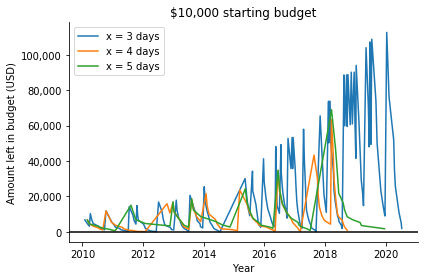

In [14]:
fig, ax = plt.subplots(tight_layout=True)
for key, value in amzn_dict2.items():
    ax.plot(amzn_date[value[:,0]], 10000-np.cumsum(amzn_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
ax.axhline(0, color="black")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("$10,000 starting budget")
ax.legend(loc="upper left")
sns.despine(fig=fig)

It seems for strategy 2, a selling decision is very conservative, because the profits come from share worth. The transaction history during the final two years shows this.

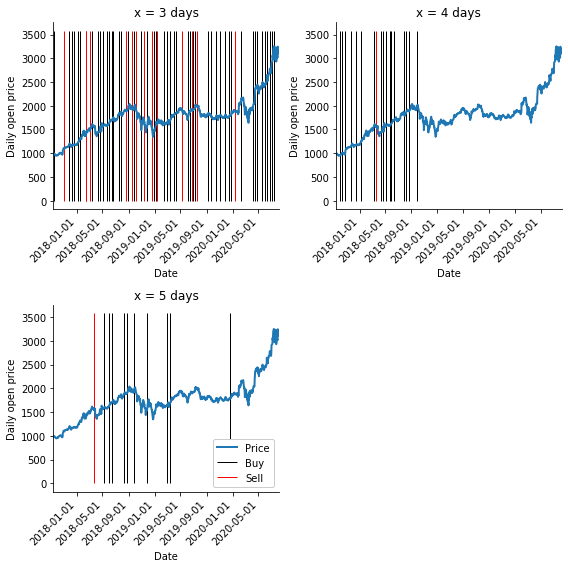

In [15]:
# Plot transaction history
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(amzn_dict2.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(amzn_date, amzn_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(amzn_date[amzn_dict2[key][amzn_dict2[key][:,1]>0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(amzn_date[amzn_dict2[key][amzn_dict2[key][:,1]<0,0]],
                          0, amzn_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(amzn_date[-2*365],amzn_date[-1])
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="lower right", framealpha=1)
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It is also clear that many buy decisions occur when the share price is increasing steadily, which is not an intention of the trading strategy. This also disallows selling, since a sell decision checks for the buying price of currently owned shares, which is ever increasing. **An additional check need to be implemented to avoid this issue.**

But first, let us test this strategy on a not-so-strong stock, United Airlines, which has been hit very hard by COVID-19.

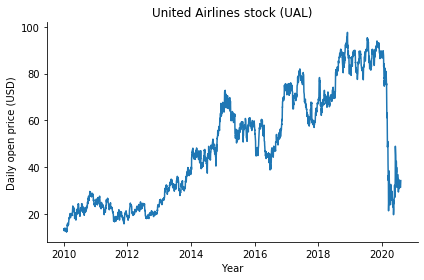

In [17]:
# Import United Airlines share
ual = yf.Ticker("UAL")
ual_price = ual.history(start="2010-01-01")
ual_price_np = ual_price["Open"].to_numpy()
ual_date = ual_price.index.to_numpy()

# Plot stock price
fig, ax = plt.subplots(tight_layout=True)
ax.plot(ual_price["Open"])
ax.set_xlabel("Year")
ax.set_ylabel("Daily open price (USD)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("United Airlines stock (UAL)")
sns.despine(fig=fig)

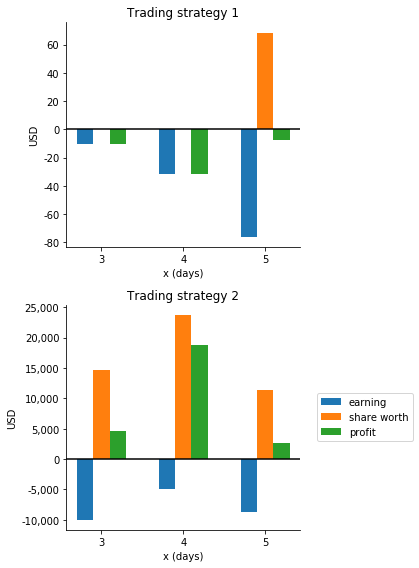

In [18]:
# Test strategy 1 and 2
ual_dict_strat1 = trading_strat1(ual_price_np, min_x=3, budget=10_000)
ual_dict_strat2 = trading_strat2(ual_price_np, min_x=3, budget=10_000)

# Plot profits
bar_width = 0.2
fig, ax = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True)
for i, j in enumerate([ual_dict_strat1,ual_dict_strat2]):
    for key, value in j.items():
        # Plot earning
        earning = -np.sum(ual_price_np[value[:,0]]*value[:,1])
        bar1 = ax[i].bar(key-bar_width, earning, width=bar_width, color=my_colors(0))

        # Plot share worth
        share_worth = np.sum(value[:,1])*ual_price_np[-1]
        bar2 = ax[i].bar(key, share_worth, width=bar_width, color=my_colors(1))

        # Plot profit
        bar3 = ax[i].bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
    ax[i].axhline(0,color='black')
    ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xticks(list(j.keys()))
    ax[i].set_xlabel("x (days)")
    ax[i].set_ylabel("USD")
    ax[i].set_title(f"Trading strategy {i+1}")
ax[-1].legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

Trading strategy 2 again outperforms strategy 1 by a significant margin. However, there is a large discrepancy between x = 4 and x = 3 or 5 days. Let's first look at the budget utilizationy.

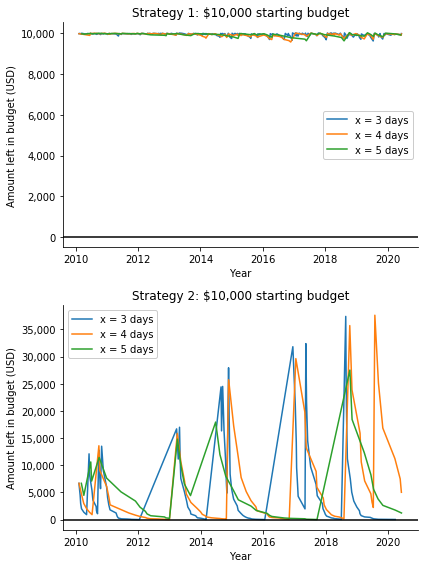

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True)
for i, j in enumerate([ual_dict_strat1,ual_dict_strat2]):
    for key, value in j.items():
        ax[i].plot(ual_date[value[:,0]], 10000-np.cumsum(ual_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
    ax[i].axhline(0, color="black")
    ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[i].set_xlabel("Year")
    ax[i].set_ylabel("Amount left in budget (USD)")
    ax[i].set_title(f"Strategy {i+1}: $10,000 starting budget")
    ax[i].legend(loc="best", framealpha=1)
sns.despine(fig=fig)

The low profit of strategy 1 is most likely because each buy decision only buys one share. Next I will inspect the transaction history of strategy 2 during the 2 years.

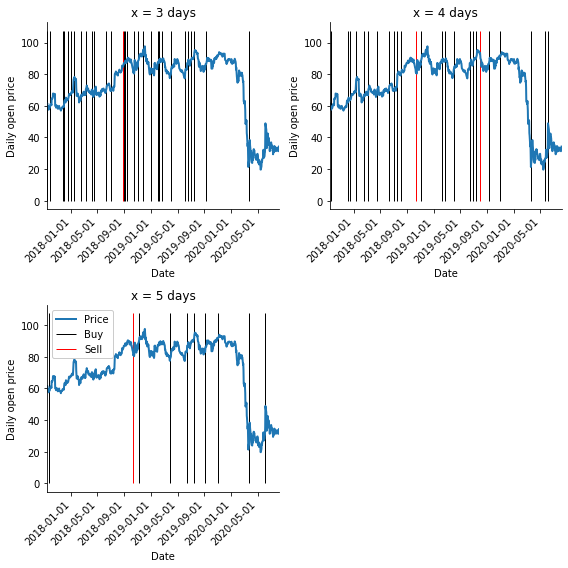

In [20]:
# Plot transaction history
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(ual_dict_strat2.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(ual_date, ual_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(ual_date[ual_dict_strat2[key][ual_dict_strat2[key][:,1]>0,0]],
                          0, ual_price_np.max()*1.1, lw=1, label="Buy")
    ax[irow, icol].vlines(ual_date[ual_dict_strat2[key][ual_dict_strat2[key][:,1]<0,0]],
                          0, ual_price_np.max()*1.1, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(ual_date[-2*365], ual_date[-1])
#     ax[irow, icol].set_ylim(0, 500)
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="best", framealpha=1)
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It is likely that the better performance of x = 4 days is due to it executing a sell decision around August 2019, thus recovering the loss that would have occured because of the crash early 2020. This is because the selling price was never above the buying price during the crash. **Therefore, I will need to add a check for stock crashing.**

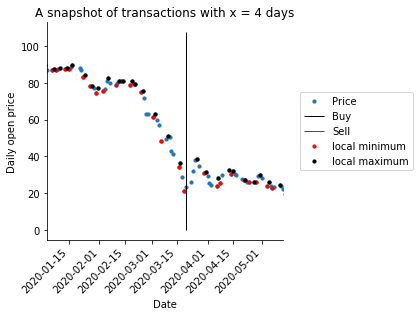

In [21]:
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.scatter(ual_date, ual_price_np, s=10, label="Price")
ax.vlines(ual_date[ual_dict_strat2[4][ual_dict_strat2[4][:,1]>0,0]],
          0, ual_price_np.max()*1.1, lw=1, label="Buy")
ax.vlines(ual_date[ual_dict_strat2[4][ual_dict_strat2[4][:,1]<0,0]],
          0, ual_price_np.max()*1.1, lw=1, color='red', label="Sell")
minima = signal.argrelmin(ual_price_np)[0]
maxima = signal.argrelmax(ual_price_np)[0]
ax.scatter(ual_date[minima], ual_price_np[minima], color='red', s=10, label="local minimum")
ax.scatter(ual_date[maxima], ual_price_np[maxima], color='black', s=10, label="local maximum")
ax.set_xlim(ual_date[-150], ual_date[-60])
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax.set_title("A snapshot of transactions with x = 4 days")
sns.despine(fig=fig)